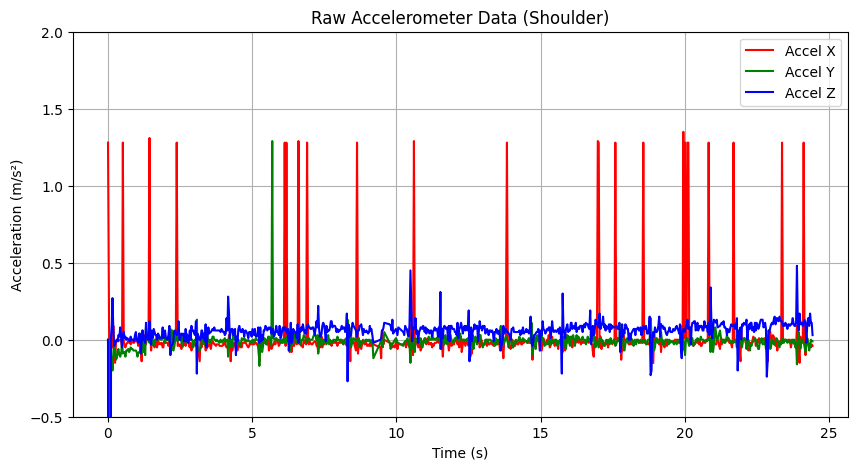

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import scipy.signal as signal


# PLOT RAW DATA

# Load the CSV file
folder_path = Path("/Users/jennifertsai/Data/Capstone/404-imu-data/sensor-on-shirt-chest-5-breaths")
file_x = folder_path / "x-axis2.csv" 
file_y = folder_path / "y-axis2.csv" 
file_z = folder_path / "z-axis2.csv" 

# Read CSV files
df_x = pd.read_csv(file_x)
df_y = pd.read_csv(file_y)
df_z = pd.read_csv(file_z)

# Read CSV files without headers, manually naming columns
df_x = pd.read_csv(file_x, header=None, names=['X', 'Time'])
df_y = pd.read_csv(file_y, header=None, names=['Y', 'Time'])
df_z = pd.read_csv(file_z, header=None, names=['Z', 'Time'])

# Assuming all files have the same 'Time' column
time = df_x['Time']
x = df_x['X']
y = df_y['Y']
z = df_z['Z']

# Plot Accelerometer Data
plt.figure(figsize=(10, 5))
plt.plot(time, x, label='Accel X', color='r')
plt.plot(time, y, label='Accel Y', color='g')
plt.plot(time, z, label='Accel Z', color='b')

# Labels and Title
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Raw Accelerometer Data (Shoulder)')

plt.ylim(-0.5,2)
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


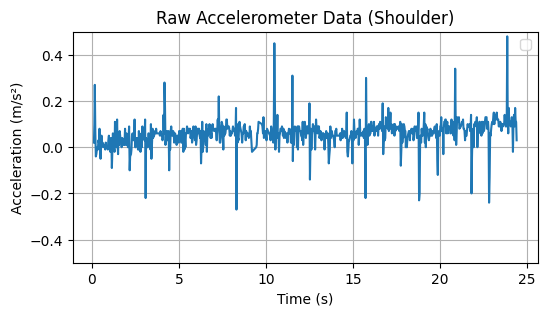

In [151]:
# Determine dominant axis (max peak-to-peak motion)
p2p_x = np.ptp(x)
p2p_y = np.ptp(y)
p2p_z = np.ptp(z)

if p2p_x > p2p_y and p2p_x > p2p_z:
    dominant_signal = x
elif p2p_y > p2p_x and p2p_y > p2p_z:
    dominant_signal = y
else:
    dominant_signal = z

N = 3
dominant_signal = dominant_signal[N:]
time = time[N:]
dominant_signal = np.nan_to_num(dominant_signal, nan=0.0)


# Plot dominant data
plt.figure(figsize=(6, 3))
plt.plot(time, dominant_signal)

# Labels and Title
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Raw Accelerometer Data (Shoulder)')

plt.ylim(-0.5,0.5)
plt.legend()
plt.grid()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


First 10 values of filtered signal: [0.0058839  0.00618591 0.00649918 0.00677802 0.00706786 0.00737103
 0.0076764  0.00798204 0.00828697 0.0085982 ]


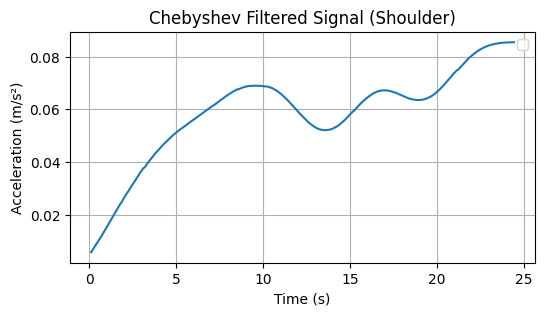

In [169]:
def chebyshev_filter(signal_data, fs=50, cutoff=0.5, order=4, rs=40):
    """ Apply a 4th-order Chebyshev Type II low-pass filter. """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    sos = signal.cheby2(order, rs, normal_cutoff, btype='low', analog=False, output='sos')
    return signal.sosfiltfilt(sos, signal_data)

fs = 50  # Sampling frequency (adjust as needed)

filtered_signal = chebyshev_filter(dominant_signal, fs)
print("First 10 values of filtered signal:", filtered_signal[:10])


# Plot dominant data
plt.figure(figsize=(6, 3))
plt.plot(time, filtered_signal)

# Labels and Title
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Chebyshev Filtered Signal (Shoulder)')

# plt.ylim(-0.5,0.5)
plt.legend()
plt.grid()
plt.show()


In [186]:
def detect_breathing_rate(filtered_signal, fs=50):
    """
    Detects breathing rate from a filtered accelerometer signal.
    
    Parameters:
        filtered_signal (array): The processed signal after applying the low-pass filter.
        fs (int): Sampling frequency (Hz).
    
    Returns:
        breathing_rate (float): Estimated breaths per minute.
    """
    # Detect peaks: Distance ensures we don't detect false positives (at least 1 second apart)
    peaks, _ = signal.find_peaks(filtered_signal, height=0, distance=fs*2)  # Minimum 1s gap

    # Calculate breaths per minute (BPM)
    duration_in_minutes = len(filtered_signal) / (fs * 60)  # Convert samples to minutes
    if duration_in_minutes == 0:
        return 0  # Prevent division by zero
    
    breathing_rate = len(peaks) / duration_in_minutes  # BPM formula
    
    return breathing_rate, peaks

# Example usage
filtered_signal = chebyshev_filter(dominant_signal, fs=50, cutoff=0.5, order=4)
bpm, _ = detect_breathing_rate(filtered_signal, fs=50)
print(f"Estimated Breathing Rate: {bpm:.2f} BPM")

Estimated Breathing Rate: 15.13 BPM


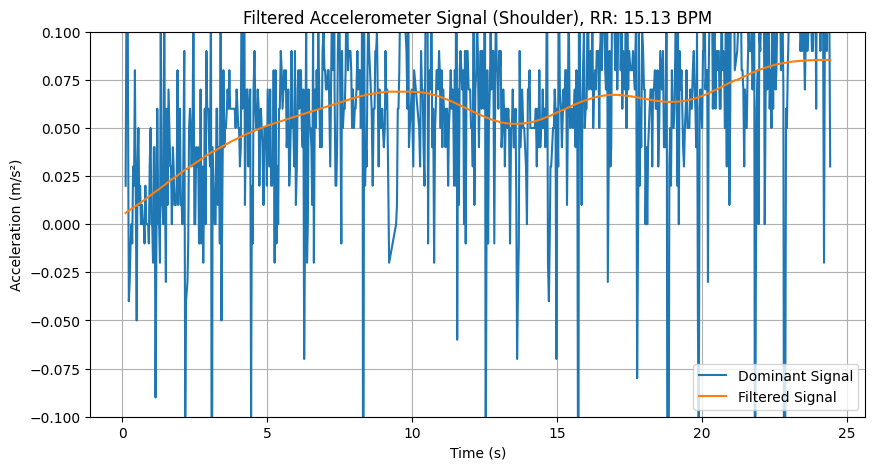

In [182]:
# Plot Accelerometer Data
plt.figure(figsize=(10, 5))
plt.plot(time, dominant_signal, label='Dominant Signal')
plt.plot(time, filtered_signal, label='Filtered Signal')

# Labels and Title
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title(f'Filtered Accelerometer Signal (Shoulder), RR: {bpm:.2f} BPM')
plt.ylim(-0.1,0.1)
plt.legend()
plt.grid()
plt.show()

In [188]:
def detect_respiratory_depression(filtered_signal, fs=50):
    """
    Detects respiratory depression by checking for:
    1. Respiratory rate < 10 BPM (Bradypnea)
    2. Breath cessation for > 15 sec (Apnea)
    
    Parameters:
        filtered_signal (array): Filtered respiration signal
        fs (int): Sampling frequency (Hz)

    Returns:
        bpm (float): Estimated breaths per minute
        apnea_detected (bool): True if no breaths detected for > 15 sec
    """

    bpm, peaks = detect_breathing_rate(filtered_signal, fs=50)

    # Detect apnea: Check peak intervals
    apnea_detected = False
    if len(peaks) > 1:
        peak_intervals = np.diff(peaks) / fs  # Convert to seconds
        if np.any(peak_intervals > 15):  # Any gap > 15s
            apnea_detected = True

    # Alerts
    if bpm < 10:
        print("⚠️ Bradypnea Detected: BPM =", bpm)
    if apnea_detected:
        print("🚨 Apnea Detected: No breath for > 15 sec!")

    return bpm, apnea_detected


bpm, apnea_detected = detect_respiratory_depression(filtered_signal, fs=50)
print(f"Estimated Breathing Rate: {bpm:.2f} BPM, Apnea Detected: {apnea_detected}")

Estimated Breathing Rate: 15.13 BPM, Apnea Detected: False
